In [1]:
#pip install git+https://github.com/uber/ludwig
#python -m spacy download en
#!pip3 install --upgrade tensorflow
#!pip install -q seaborn

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn_xarray import wrap
from sklearn.preprocessing import MinMaxScaler
#from ludwig.api import LudwigModel
#from ludwig.utils.data_utils import add_sequence_feature_column
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

**OBTAINING THE DATASET**

In [3]:
ds_combine = xr.open_dataset("./wikilimoXArrayData.nc")
ds_combine

<xarray.Dataset>
Dimensions:    (latitude: 1801, longitude: 3600, time: 31)
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 2019-12-01T12:00:00 ... 2019-12-31T12:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    swvl1      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-11-25 11:37:48 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [36]:
df = pd.read_pickle("./wikilimoData.pkl")
df

t2m            tp     swvl1
latitude longitude  time                                                   
 90.0    0.000000   2019-12-01 12:00:00         NaN           NaN       NaN
                    2019-12-02 12:00:00         NaN           NaN       NaN
                    2019-12-03 12:00:00         NaN           NaN       NaN
                    2019-12-04 12:00:00         NaN           NaN       NaN
                    2019-12-05 12:00:00         NaN           NaN       NaN
...                                             ...           ...       ...
-90.0    359.899994 2019-12-27 12:00:00  246.587769  8.350611e-05  0.206098
                    2019-12-28 12:00:00  249.062820  1.202524e-04  0.206098
                    2019-12-29 12:00:00  246.191711  7.450581e-09  0.206098
                    2019-12-30 12:00:00  247.661133  1.336634e-05  0.206098
                    2019-12-31 12:00:00  243.946350  7.450581e-09  0.206098

[200991600 rows x 3 columns]

**PREPROCESSING THE DATA**

Finding number of rows with null values

In [3]:
df.isna().sum()

t2m      132392847
tp       132392847
swvl1    132392847
dtype: int64

Dropping the rows which have null values

In [37]:
df= df.dropna()

In [5]:
df

t2m            tp     swvl1
latitude longitude  time                                                   
 83.5    323.399994 2019-12-01 12:00:00  252.746674  3.345311e-06  0.178162
                    2019-12-02 12:00:00  253.231079  7.450581e-09  0.178162
                    2019-12-03 12:00:00  252.360916  1.002848e-05  0.178162
                    2019-12-04 12:00:00  254.342712  6.683171e-06  0.178162
                    2019-12-05 12:00:00  252.896851  7.349253e-05  0.178162
...                                             ...           ...       ...
-90.0    359.899994 2019-12-27 12:00:00  246.587769  8.350611e-05  0.206098
                    2019-12-28 12:00:00  249.062820  1.202524e-04  0.206098
                    2019-12-29 12:00:00  246.191711  7.450581e-09  0.206098
                    2019-12-30 12:00:00  247.661133  1.336634e-05  0.206098
                    2019-12-31 12:00:00  243.946350  7.450581e-09  0.206098

[68598753 rows x 3 columns]

In [38]:
df['tp'] = np.log(df['tp'])

<ipython-input-38-fc46ea5b3a2f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tp'] = np.log(df1['tp'])


Performing log tranform to remove skewness of data

In [7]:
df

t2m         tp     swvl1
latitude longitude  time                                                
 83.5    323.399994 2019-12-01 12:00:00  252.746674 -12.607951  0.178162
                    2019-12-02 12:00:00  253.231079 -18.714973  0.178162
                    2019-12-03 12:00:00  252.360916 -11.510081  0.178162
                    2019-12-04 12:00:00  254.342712 -11.915918  0.178162
                    2019-12-05 12:00:00  252.896851  -9.518327  0.178162
...                                             ...        ...       ...
-90.0    359.899994 2019-12-27 12:00:00  246.587769  -9.390591  0.206098
                    2019-12-28 12:00:00  249.062820  -9.025918  0.206098
                    2019-12-29 12:00:00  246.191711 -18.714973  0.206098
                    2019-12-30 12:00:00  247.661133 -11.222771  0.206098
                    2019-12-31 12:00:00  243.946350 -18.714973  0.206098

[68598753 rows x 3 columns]

In [8]:
normalized_df=(df-df.min())/(df.max()-df.min())

Performing min max normalization to 
avoid higher influence of temperature at 2m compared to
volumetric soil water layer on predicting the precipitation
of a region.

In [9]:
normalized_df

t2m        tp     swvl1
latitude longitude  time                                             
 83.5    323.399994 2019-12-01 12:00:00  0.326065  0.355146  0.232585
                    2019-12-02 12:00:00  0.331085  0.000000  0.232585
                    2019-12-03 12:00:00  0.322067  0.418991  0.232585
                    2019-12-04 12:00:00  0.342606  0.395390  0.232585
                    2019-12-05 12:00:00  0.327621  0.534819  0.232585
...                                           ...       ...       ...
-90.0    359.899994 2019-12-27 12:00:00  0.262234  0.542248  0.269055
                    2019-12-28 12:00:00  0.287886  0.563455  0.269055
                    2019-12-29 12:00:00  0.258130  0.000000  0.269055
                    2019-12-30 12:00:00  0.273359  0.435700  0.269055
                    2019-12-31 12:00:00  0.234859  0.000000  0.269055

[68598753 rows x 3 columns]

**DEVELOPING THE MODEL**

From the data visualization through plotting, we understood that 
the total precipitation of a specific geo spatial point varies wrt 
to the date highly but doesn't change much when comparing
wrt to latitude and logitude, except for a few regions.

But since the temperature at 2m and volumetric soil water layer also
vary wrt to the time and latitude and longitude variables,
we will build considering the simple case of just ignoring the 
time and geo spatial variables and predicting the total precipitation by considering
dependence only on temperature at 2m and volumetric soil water layer.

Since we have sufficiently large data, we can afford to take
large % of dataset for training, but considering 
the computation power available to build the model
I am taking the split to be 60:20:20 for training, validation and
testing.

Splitting the data.
60% for training
20% for validation
20% for testing and evaluating the model


In [10]:
train_df = normalized_df[:int(0.8*68598753)]

In [11]:
test_df = normalized_df[len(train_df.index)+1:]

Taking the values to be predicted into lables.

In [12]:
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features['tp']
test_labels = test_features['tp']

In [13]:
train_labels

latitude    longitude   time               
 83.500000  323.399994  2019-12-01 12:00:00    0.355146
                        2019-12-02 12:00:00    0.000000
                        2019-12-03 12:00:00    0.418991
                        2019-12-04 12:00:00    0.395390
                        2019-12-05 12:00:00    0.534819
                                                 ...   
-77.699997  239.899994  2019-12-08 12:00:00    0.355146
                        2019-12-09 12:00:00    0.482837
                        2019-12-10 12:00:00    0.563455
                        2019-12-11 12:00:00    0.000000
                        2019-12-12 12:00:00    0.588100
Name: tp, Length: 54879002, dtype: float32

Defining normalizer to include normalization to the model layer

In [14]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[0.53223556 0.37503037 0.35637796]


In [15]:
def build_and_compile_model(norm):
    
  """
    Defining the Deep neural network model
  """  
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])
    
  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

Mean squared error is taken as the loss function instead of 
mean absolute error, for faster 
convergence of the error and for imposing more penalty for huge
errors compared to small errors.

Using adam's optimizer to enhance the performance of the model.

Using relu activation function.

In [16]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


Training the model with 2 epochs and 20% validation split
Taking only one epoch due to computational power limitation.

In [17]:
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1)

In [26]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.0000000001])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

In [ ]:
#plot_loss(history)

In [28]:
history.history['loss']

[1.5288669601432048e-06]

In [29]:
history.history['val_loss']

[5.196705843424354e-10]

Obtaining predictions

In [30]:
test_predictions = dnn_model.predict(test_features).flatten()

In [32]:
test_predictions

array([5.0663948e-07, 4.7599190e-01, 7.3399782e-01, ..., 5.9604645e-07,
       4.3569973e-01, 5.0663948e-07], dtype=float32)

Scatter plot to visualize how close
the true values and predictions are.

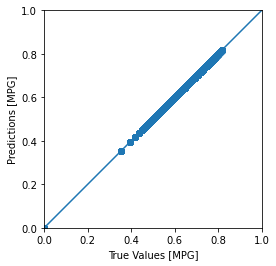

In [31]:
a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

From the scatter plot, we see that there is an almost 
linear relationship between true values and predictions. 

We have chosen a medium capacity architecture for our model.
The model is not overfitting or underfitting to the training data as it is giving close results to test data. 

If it were underfitting, we would have added a few more layers and re built the model.
For example, the architecture would be: 

normalization (Normalization (None, 3)                  
_________________________________________________________________
dense (Dense)                (None, 512)            
_________________________________________________________________
dense_1 (Dense)              (None, 512)                  
_________________________________________________________________
dense_2 (Dense)              (None, 512)                      
_________________________________________________________________
dense_3 (Dense)              (None, 512)            
_________________________________________________________________
dense_4 (Dense)              (None, 1)                  
_________________________________________________________________
                    

If it were overfitting we would have removed a hidden layer or changed the layer size and checked.

We could have taken the following arcitecture:

normalization (Normalization (None, 3)                      
_________________________________________________________________
dense (Dense)                (None, 16)                     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                      
_________________________________________________________________

Or: 

normalization (Normalization (None, 3)                  
_________________________________________________________________
dense (Dense)                (None, 64)            
_________________________________________________________________
dense_2 (Dense)              (None, 1)                      
_________________________________________________________________


Along with adams optimzer we could also use tf.keras.optmizers.schedules to gradually reduce the learning rate,
but since we are taking only single epoch, it is not taken. 

The functions would be:
    step = np.linspace(0,100000)
    lr = lr_schedule(step)

We could also have added weight regularization to the loss function, to avoid overfitting. The code would change as:

layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)) 

Also could have considered adding drop out to few of the layers.
The code would change as:
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu')
and could have added few combinations of the above techniques together.

In [32]:
error = test_predictions - test_labels

In [33]:
error

latitude    longitude   time               
-77.699997  239.899994  2019-12-14 12:00:00   -0.000016
                        2019-12-15 12:00:00   -0.000019
                        2019-12-16 12:00:00   -0.000030
                        2019-12-17 12:00:00   -0.000024
                        2019-12-18 12:00:00   -0.000019
                                                 ...   
-90.000000  359.899994  2019-12-27 12:00:00   -0.000027
                        2019-12-28 12:00:00   -0.000028
                        2019-12-29 12:00:00   -0.000014
                        2019-12-30 12:00:00   -0.000023
                        2019-12-31 12:00:00   -0.000014
Name: tp, Length: 13719750, dtype: float32

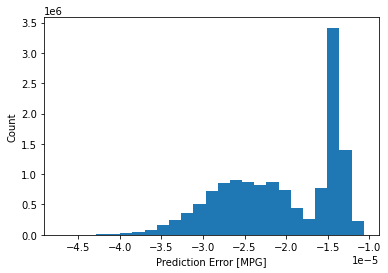

In [34]:
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

Histogram to visualize the error distribution

From the histogram we see that the distribution of error range is 
towards negative x axis meaning that the most prediction values are less than true values.

But a good behaviour we observe is that the count decreases as the 
error goes to extremes.

Applying  inverse log transform since we applied log transform to total precipitation data before training.

In [43]:
test_labels = np.exp(test_labels)
test_predictions = np.exp(test_predictions)

Finding percentage error

In [44]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

Taking MAPE as the metric to evaluate the model, since the
values a extremely small, in range of e-7, using just MSE or RMSE
will mislead in evaluating the model

In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [46]:
print('\nMean absolute percentage error: %f'%mean_absolute_percentage_error(test_labels,test_predictions))


Mean absolute percentage error: 0.002062


In [47]:
dnn_model.save('dnn_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: dnn_model/assets


If we had considered the dependence of total precipitation on
date and time too to predict, the total
precipitation would have been more accurate while predicting for
a specific date or time.